#### 환경 설정

1. 필요한 라이브러리 다운

In [1]:
! pip install ultralytics
! pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [2]:
### 모델 관련 ----
import ultralytics
from ultralytics import YOLO
# 제대로 설치되었는지 확인하는 코드
ultralytics.checks()
### 경로 설정 시 ----
import os
### 바운딩박스 생성 시 ----
from PIL import Image
### 데이터 증강 ----
import albumentations as A
from albumentations.pytorch import ToTensorV2
### 데이터 분리할 때 사용 ----
import random
import shutil
### yaml 파일 생성 ----
import yaml
#### 그림 그리고, 레이블링 할 때 ----
import cv2
import matplotlib.pyplot as plt
### 혹시 모르니까 설치하는 부분 ----
import pandas as pd
import numpy as np

Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.3/112.6 GB disk)


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


2. 경로 설정

In [3]:
### 데이터 ---- *나중에 없으면 만들도록 할 수 있음! 일단 정해만 두기
# 현재 데이터 있는 곳
base_path = "/content/drive/MyDrive/5. MY LOVE/기학지 플젝/DATA/LA"
# 데이터 분리해서 담아둘 곳 (train, val / image, label 분리)
to_path = "/content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_CLS/Model_LA/DATA_LA/"

### YAML 파일 담을 곳 ----
yaml_path = "/content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_CLS/Model_LA/YAML_LA/"

### 결과 파일 담을 곳 ----
results_path = "/content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_CLS/Model_LA/Results"

In [ ]:
# 만들고 들어오기 귀찮아요,,,
paths = ["/content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_CLS/Model_LA/DATA_LA",
              "/content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_CLS/Model_LA/YAML_LA",
              "/content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_CLS/Model_LA/Results"]

for path in paths:
    if not os.path.exists(path):
        os.makedirs(path)

#### 데이터 준비

1. 바운딩박스 만들기

In [ ]:
# 전체 파일 읽어오기
files_list = [file for file in os.listdir(base_path) if file.endswith(".csv")]

# 전체 파일 이름 읽어오기
file_names = [os.path.splitext(file)[0] for file in os.listdir(base_path) if file.endswith(".csv")]
file_names[:5]

['0135-F-024Y1',
 '0149-M-062Y1',
 '0151-M-079Y1',
 '0152-F-026Y1',
 '0157-M-060Y1']

In [ ]:
all_points = []
for file in files_list:
    points = pd.read_csv(os.path.join(base_path, file), header = None)
    points = points.drop(index = 10)
    points = points.iloc[:,4]
    points = points.values.tolist()
    all_points.extend(points)

In [ ]:
pd.Series(all_points).value_counts()

,count
0,3934
3,57
4,9


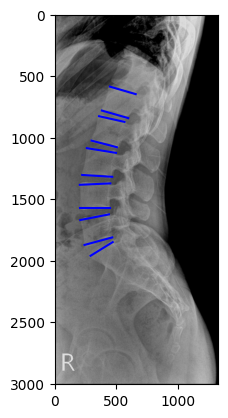

In [ ]:
# 첫 사진, 설명 경로
first_image_path = "/content/drive/MyDrive/5. MY LOVE/기학지 플젝/DATA/LA/0135-F-024Y1.jpg"
first_text_path = "/content/drive/MyDrive/5. MY LOVE/기학지 플젝/DATA/LA/0135-F-024Y1.csv"

# 이미지 불러오기
image = cv2.imread(first_image_path)

# 좌표 불러오기
points = pd.read_csv(first_text_path, header = None)
points = points.drop(4, axis = 1)
points = points.values.tolist()

plt.imshow(image)
for (x1, y1, x2, y2) in points:
    plt.plot([x1, x2], [y1, y2], 'b-')
plt.show()

In [ ]:
# 한 장 가지고 진행한다고 생각 - 두 줄로 바운딩박스 만드는 함수
def create_bbox_2lines(line1, line2, width, height):
    # x, y 좌표 읽기
    x_coords = [line1[0], line1[2], line2[0], line2[2]]
    y_coords = [line1[1], line1[3], line2[1], line2[3]]

    # 최대, 최소
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)

    # 중심, 크기
    x_center = (x_min + x_max) / 2 / width
    y_center = (y_min + y_max) / 2 / height
    bb_width = (x_max - x_min) / width
    bb_height = (y_max - y_min) / height

    # 라벨
    class_id = 1 if int(line1[4]) in [3, 4] or int(line2[4]) in [3, 4] else 0

    return [class_id, x_center, y_center, bb_width, bb_height]

# 한 장 전체
def create_bbox_pic(file_name, width, height):
    bb_csv_path = f"/content/drive/MyDrive/5. MY LOVE/기학지 플젝/DATA/LA/{file_name}.csv"
    lines = pd.read_csv(bb_csv_path, header = None)
    yolo_boxes = []
    class_ids = []
    for i in range(0, len(lines)-2, 2):
        yolo_box = create_bbox_2lines(
            lines.iloc[i].tolist(),
            lines.iloc[i+1].tolist(),
            width, height)
        yolo_boxes.append(yolo_box)
        class_ids.append(yolo_box[0]) # 비정상 데이터 따로 가져오기 위해 class_id만 따로 모아두기

    # 저장하기
    txt_path = f"/content/drive/MyDrive/5. MY LOVE/기학지 플젝/DATA/LA/{file_name}_cls.txt"
    with open(txt_path, "w") as f:
        for box in yolo_boxes:
            f.write(' '.join(map(str, box)) + '\n')

    # class_id 반환 (한 장에 대한 5개의 값)
    return class_ids

# 여러 장으로 확장
def make_bbox(file_names):
    abnormal_names = []
    for file_name in file_names: # 이름 하나 받아서

        # Width, Height 출력
        bb_image_path = f"/content/drive/MyDrive/5. MY LOVE/기학지 플젝/DATA/LA/{file_name}.jpg"
        image = Image.open(bb_image_path)
        width, height = image.size

        # 한 장 전체에서 bounding box + class_id 확인
        class_ids = create_bbox_pic(file_name, width, height)

        # 비정상 데이터 모으기
        if 1 in class_ids:
            abnormal_names.append(file_name)

    return abnormal_names

In [ ]:
abnormal_names = make_bbox(file_names)

In [ ]:
abnormal_names # 59장

['0034-F-067Y1',
 '0054-F-079Y1',
 '0056-F-069Y1',
 '0147-F-086Y1',
 '0121-F-072Y1',
 '0113-F-082Y1',
 '0158-F-072Y1',
 '0159-M-062Y1',
 '0164-F-064Y1',
 '0167-F-049Y1',
 '0187-F-067Y1',
 '0194-F-077Y1',
 '0201-F-077Y1',
 '0202-F-068Y1',
 '0218-M-067Y1',
 '0223-F-063Y1',
 '0234-F-073Y1',
 '0235-F-073Y1',
 '0236-M-065Y1',
 '0242-M-066Y1',
 '0243-M-068Y1',
 '0245-F-086Y1',
 '0250-F-069Y1',
 '0259-F-073Y1',
 '0277-F-050Y1',
 '0291-M-073Y1',
 '0300-M-083Y1',
 '0306-M-072Y1',
 '0316-F-074Y1',
 '0332-M-084Y1',
 '0334-F-058Y1',
 '0342-F-060Y1',
 '0363-F-062Y1',
 '0378-F-075Y1',
 '0395-M-080Y1',
 '0411-F-066Y1',
 '0415-F-061Y1',
 '0420-F-079Y1',
 '0423-M-065Y1',
 '0436-F-054Y1',
 '0437-F-065Y1',
 '0446-M-060Y1',
 '0452-M-042Y1',
 '0453-F-064Y1',
 '0464-F-074Y1',
 '0466-F-046Y1',
 '0469-F-068Y1',
 '0470-F-065Y1',
 '0471-M-081Y1',
 '0472-F-070Y1',
 '0477-F-075Y1',
 '0485-M-062Y1',
 '0487-F-047Y1',
 '0219-F-077Y1',
 '0230-F-078Y1',
 '0262-F-084Y1',
 '0265-F-081Y1',
 '0284-F-061Y1',
 '0285-F-061Y1

In [ ]:
len(abnormal_names)

59

추가) 데이터 증강

- 비정상인 사진들에 대해서만 진행 (한 장당 25장씩 추가로)
  - 밝기, 대비 변화
  - 픽셀에 노이즈 추가
  - 흐림 효과
일단 요 정도만...

In [ ]:
# 증강 함수 정의
transform = A.Compose([
    A.RandomBrightnessContrast(p = 0.5), # 밝기, 대비 조절
    A.GaussNoise(var_limit = (10.0, 40.0), mean = 0, p=0.3), # 가우시안 노이즈
    A.MotionBlur(blur_limit = 3, p=0.2) # 블러
])

# 증강할 개수
n_augments = 25

# 증강 진행, 저장까지 - 5분 정도 소요
for file_name in abnormal_names:
    # 경로 설정
    image_path = os.path.join(base_path, f"{file_name}.jpg")
    txt_path = os.path.join(base_path, f"{file_name}_cls.txt")

    # 이미지 로드
    image = np.array(Image.open(image_path))

    # 이미지 증강
    for i in range(1, n_augments + 1):
        augmented = transform(image = image)
        augmented_image = augmented['image']

        # 이미지, 바운딩박스 저장
        new_name = f"{file_name}_a{i}"
        new_image_path = os.path.join(base_path, f"{new_name}.jpg")
        new_txt_path = os.path.join(base_path, f"{new_name}_cls.txt")

        cv2.imwrite(new_image_path, augmented_image)
        shutil.copyfile(txt_path, new_txt_path)

<ipython-input-20-a1c0885a6d19>:4: UserWarning: Argument(s) 'var_limit, mean' are not valid for transform GaussNoise
  A.GaussNoise(var_limit = (10.0, 40.0), mean = 0, p=0.3), # 가우시안 노이즈


In [ ]:
# 전체 파일 읽어오기 - Again (증강한 데이터 추가)
files_list = [file for file in os.listdir(base_path) if file.endswith(".jpg")]

# 전체 파일 이름 읽어오기 - Again (증강한 데이터 추가)
file_names = [os.path.splitext(file)[0] for file in os.listdir(base_path) if file.endswith(".jpg")]
len(file_names) # 700개라면 잘 진행된 것 !

1875

2. 데이터 분리 (train,val / image, label)

In [ ]:
### 폴더 생성
# 이미지/ 라벨 분리
img_ = '.jpg'
label_ = '.txt'

# 저장 경로 만들기
folders_list = [os.path.join(to_path, 'train'),
                os.path.join(to_path, 'val'),
                os.path.join(to_path, 'train/images'),
                os.path.join(to_path, 'val/images'),
                os.path.join(to_path, 'train/labels'),
                os.path.join(to_path, 'val/labels')]

# 없으면 생성해주세용
for folder in folders_list:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [ ]:
### 데이터 분리 - 2분 정도 소요
# 1. 데이터 섞고
random.shuffle(files_list)

# 2. Train/Test 분리
ratio = 0.8
train_list = files_list[: int(len(files_list) * ratio)]
test_list = files_list[int(len(files_list) * ratio) :]

# 3. File 이동
for i in train_list: # train
    file_name = os.path.splitext(i)[0] # 파일 이름
    shutil.copyfile(os.path.join(base_path, (file_name + img_)), os.path.join(to_path, 'train/images', (file_name + img_)))
    shutil.copyfile(os.path.join(base_path, (file_name + "_cls" + label_)), os.path.join(to_path, 'train/labels', (file_name + label_)))

for i in test_list: # test
    file_name = os.path.splitext(i)[0] # 파일 이름
    shutil.copyfile(os.path.join(base_path, (file_name + img_)), os.path.join(to_path, 'val/images', (file_name + img_)))
    shutil.copyfile(os.path.join(base_path, (file_name + "_cls" + label_)), os.path.join(to_path, 'val/labels', (file_name + label_)))

3. YAML 파일 만들기

In [ ]:
classes = []
for name in file_names:
    check_txt_path = f"/content/drive/MyDrive/5. MY LOVE/기학지 플젝/DATA/LA/{name}_cls.txt"
    txt_file = pd.read_csv(check_txt_path, delimiter = ' ', header = None)
    classs = txt_file.iloc[:, 0] # 첫 열만 가져오기
    classes.extend(classs.tolist())

uniq_classes = pd.Series(classes)
uniq_classes.value_counts()

,count
0,7659
1,1716


In [ ]:
# 폴더 없으면 만들기
if not os.path.exists(yaml_path):
    os.makedirs(yaml_path)

# 그 폴더로 들어가기
os.chdir(yaml_path)

# YAML 파일
data = dict()

# 경로 설정
data['train'] = os.path.join(to_path, 'train')
data['val'] = os.path.join(to_path, 'val')
data['test'] = os.path.join(to_path, 'val')

# 클래스 수
data['class'] = 2
data['names'] = ['Normal', 'Abnormal'] # 정상, 오른쪽으로 휨, 왼쪽으로 휨

# YAML 파일로 저장
with open('spine_la.yaml', 'w') as f:
    yaml.dump(data, f)

#### Train

In [ ]:
from ultralytics import YOLO
# 모델 불러오기
model = YOLO('yolov8s.yaml')
# 학습 코드
results = model.train(data = 'spine_la.yaml',
                      epochs = 20,
                      batch = 32, # 일반적으로 32
                      imgsz = (640, 400), # 입력 이미지 크기 고정 (세로로 긴 직사각형)
                      # - 사전에 안 고치고 진행할거면 이렇게 하면 됨 (근데 데이터 왜곡이 조금 있을 수도 있대)
                      device = 0, # 0이 GPU
                      patience = 5, # 성능 향상이 없는 경우 기다릴 epoch
                      name = 'trained_la', # 저장할 이름
                      project = results_path)

Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=spine_la.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=(640, 400), int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=trained_la, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective=0.0, plots=True, pose=12.0, pretrained=True,

100%|██████████| 755k/755k [00:00<00:00, 16.4MB/s]

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  1   1969152  ultralytics.nn.modules.block.C2f             [768, 512, 1]                 
 22        [15, 18, 21]  1   2116822  ultralytics.nn.modules.head.Detect           [2, [128, 256, 512]]          
YOLOv8s summary: 129 layers, 11,136,374 parameters, 11,136,358 gradients, 28.6 GFLOPs

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 86.7MB/s]


AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=640'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'
train: Fast image access ✅ (ping: 0.6±0.1 ms, read: 137.4±82.9 MB/s, size: 1869.5 KB)


train: Scanning /content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_CLS/Model_LA/DATA_LA/train/labels... 1500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1500/1500 [00:30<00:00, 49.64it/s]


train: New cache created: /content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_CLS/Model_LA/DATA_LA/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
WARNING ⚠️ val: Slow image access detected (ping: 38.1±80.6 ms, read: 86.7±51.2 MB/s, size: 1762.0 KB). Use local storage instead of remote/mounted storage for better performance. See https://docs.ultralytics.com/guides/model-training-tips/


val: Scanning /content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_CLS/Model_LA/DATA_LA/val/labels... 375 images, 0 backgrounds, 0 corrupt: 100%|██████████| 375/375 [00:07<00:00, 48.25it/s]


val: New cache created: /content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_CLS/Model_LA/DATA_LA/val/labels.cache
Plotting labels to /content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_CLS/Model_LA/Results/trained_la/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_CLS/Model_LA/Results/trained_la
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      7.07G      4.326      3.735      3.937        241        640: 100%|██████████| 47/47 [01:53<00:00,  2.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:16<00:00,  2.75s/it]

                   all        375       1875    0.00114     0.0669   0.000649   0.000115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      6.84G      2.756      2.736      2.704        221        640: 100%|██████████| 47/47 [01:47<00:00,  2.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:14<00:00,  2.37s/it]

                   all        375       1875     0.0018      0.114    0.00114    0.00018



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      7.18G      2.184      2.002      2.102        267        640: 100%|██████████| 47/47 [01:46<00:00,  2.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:14<00:00,  2.39s/it]

                   all        375       1875      0.313      0.361      0.248      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      6.83G      1.783      1.578      1.718        211        640: 100%|██████████| 47/47 [01:47<00:00,  2.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:13<00:00,  2.19s/it]

                   all        375       1875      0.437      0.594      0.485      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      7.19G      1.501      1.331      1.498        247        640: 100%|██████████| 47/47 [01:46<00:00,  2.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:13<00:00,  2.32s/it]

                   all        375       1875      0.492      0.572      0.531      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.83G      1.309      1.154       1.37        254        640: 100%|██████████| 47/47 [01:44<00:00,  2.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:14<00:00,  2.36s/it]

                   all        375       1875      0.548      0.593      0.564      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       7.2G      1.216      1.079      1.297        227        640: 100%|██████████| 47/47 [01:48<00:00,  2.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.14s/it]

                   all        375       1875      0.564      0.753      0.644      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.84G      1.142      1.006      1.242        259        640: 100%|██████████| 47/47 [01:45<00:00,  2.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.51s/it]

                   all        375       1875      0.564      0.841      0.713      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       7.2G      1.114       0.94      1.221        255        640: 100%|██████████| 47/47 [01:45<00:00,  2.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.14s/it]

                   all        375       1875      0.694      0.751      0.766      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.82G      1.031     0.8582      1.172        254        640: 100%|██████████| 47/47 [01:47<00:00,  2.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.11s/it]

                   all        375       1875      0.745      0.791      0.842      0.639


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      7.09G      0.926     0.7966      1.204        139        640: 100%|██████████| 47/47 [01:55<00:00,  2.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:14<00:00,  2.44s/it]

                   all        375       1875      0.767      0.805      0.859      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.74G     0.8687     0.6839       1.16        138        640: 100%|██████████| 47/47 [01:42<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.07s/it]

                   all        375       1875      0.861      0.854      0.926      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       7.1G     0.8319     0.6194      1.131        140        640: 100%|██████████| 47/47 [01:45<00:00,  2.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.14s/it]

                   all        375       1875      0.913      0.874      0.953      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      7.04G     0.7932     0.5686      1.103        139        640: 100%|██████████| 47/47 [01:43<00:00,  2.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.01s/it]

                   all        375       1875       0.94      0.911      0.972      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      7.09G     0.7562     0.5272      1.074        140        640: 100%|██████████| 47/47 [01:42<00:00,  2.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.13s/it]

                   all        375       1875       0.94      0.925       0.98        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.74G     0.7325     0.4963      1.058        138        640: 100%|██████████| 47/47 [01:40<00:00,  2.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:13<00:00,  2.25s/it]

                   all        375       1875      0.953      0.935      0.987      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      7.08G     0.6999     0.4589      1.045        140        640: 100%|██████████| 47/47 [01:45<00:00,  2.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:13<00:00,  2.17s/it]

                   all        375       1875      0.952      0.939      0.983      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      7.04G     0.6652     0.4326      1.026        139        640: 100%|██████████| 47/47 [01:43<00:00,  2.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:11<00:00,  2.00s/it]

                   all        375       1875      0.961      0.953      0.989      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      7.08G     0.6507      0.409      1.008        140        640: 100%|██████████| 47/47 [01:42<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:13<00:00,  2.32s/it]

                   all        375       1875      0.952      0.964      0.987      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      7.04G     0.6124       0.39     0.9909        140        640: 100%|██████████| 47/47 [01:45<00:00,  2.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.06s/it]

                   all        375       1875      0.962      0.971      0.992       0.88



20 epochs completed in 0.677 hours.
Optimizer stripped from /content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_CLS/Model_LA/Results/trained_la/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_CLS/Model_LA/Results/trained_la/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_CLS/Model_LA/Results/trained_la/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:24<00:00,  4.09s/it]


                   all        375       1875      0.962      0.971      0.992       0.88
                Normal        375       1533      0.973       0.98      0.993      0.875
              Abnormal        307        342      0.952      0.962      0.991      0.885
Speed: 0.3ms preprocess, 4.0ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to /content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_CLS/Model_LA/Results/trained_la


#### Inference


0: 640x448 4 Normals, 1 Abnormal, 41.7ms
Speed: 14.8ms preprocess, 41.7ms inference, 385.8ms postprocess per image at shape (1, 3, 640, 448)
5개의 박스가 만들어졌어용..!


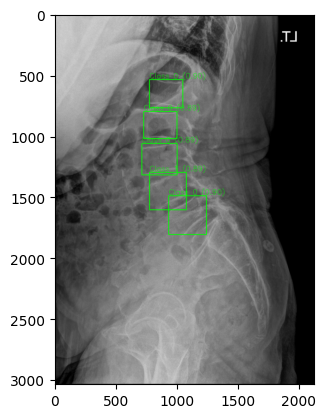


이 환자는 척추 전위증이 있습니다.


In [6]:
### Inference
model_path = '/content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_CLS/Model_LA/Results/trained_la/weights/best.pt'
model = YOLO(model_path)

test_img_path = '/content/drive/MyDrive/5. MY LOVE/기학지 플젝/DATA/LA/0147-F-086Y1.jpg'
test_img = cv2.imread(test_img_path)

# cls, box 좌표 추출
classes = []
bounding_boxes = []

# Inference
results = model(test_img)

for result in results:
    boxes = result.boxes
    print(f"{len(boxes)}개의 박스가 만들어졌어용..!")
    confs = boxes.conf.cpu().numpy()
    coords = boxes.xyxy.cpu().numpy()

    for box in boxes:

        cls = int(box.cls[0])
        conf = float(box.conf[0])
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        # 저장
        classes.append(cls)
        bounding_boxes.append([x1, y1, x2, y2])

        label = f"Class {cls} ({conf:.2f})"
        color = (0, 255, 0)
        cv2.rectangle(test_img, (x1, y1), (x2, y2), color, 5)
        cv2.putText(test_img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, color, 2)

plt.imshow(test_img)
plt.show()

# 추가) 전위증 판단
if 1 in classes:
    print("\n이 환자는 척추 전위증이 있습니다.")
else:
    print("\n이 환자는 척추 전위증이 없습니다.")

In [ ]:
### classes에 1이 있는지 여부로 전위증 판단하고
### bounding_boxes에 바운딩박스 좌표 담아둠 - y1 값 기준으로 정렬해서 사용하면 위에서부터 내려오게 정렬 가능

In [ ]:
bounding_boxes

[[932, 1490, 1242, 1808],
 [774, 537, 1048, 769],
 [712, 1061, 1001, 1319],
 [727, 799, 1000, 1021],
 [775, 1298, 1077, 1605]]

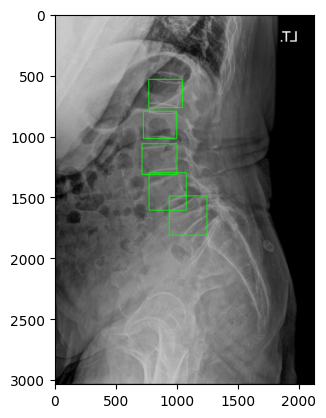

In [8]:
### 실제랑 비교
# 첫 사진, 설명 경로
first_image_path = '/content/drive/MyDrive/5. MY LOVE/기학지 플젝/DATA/LA/0147-F-086Y1.jpg'
first_bb_path = "/content/drive/MyDrive/5. MY LOVE/기학지 플젝/DATA/LA/0147-F-086Y1_cls.txt"

# 이미지 불러오기
image = cv2.imread(first_image_path)
height, width, _ = image.shape

# 바운딩박스 그리기
with open(first_bb_path, "r") as f:
    lines = f.readlines()
for line in lines:
    parts = line.strip().split()
    class_id, x_center, y_center, box_w, box_h = map(float, parts)

    # YOLO 형식 → 픽셀 좌표 복원
    x_center *= width
    y_center *= height
    box_w *= width
    box_h *= height

    x1 = int(x_center - box_w / 2)
    y1 = int(y_center - box_h / 2)
    x2 = int(x_center + box_w / 2)
    y2 = int(y_center + box_h / 2)

    # 박스 그리기
    color = (0, 255, 0)
    cv2.rectangle(image, (x1, y1), (x2, y2), color, 5)

plt.imshow(image)
plt.show()

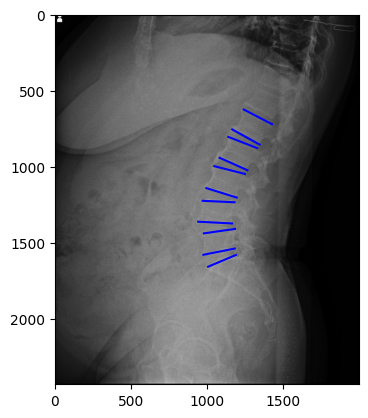

In [ ]:
### 기존 요추 선
# 첫 사진, 설명 경로
first_image_path = '/content/drive/MyDrive/기학지 플젝/DATA/LA/0034-F-067Y1.jpg'
first_text_path = "/content/drive/MyDrive/기학지 플젝/DATA/LA/0034-F-067Y1.csv"

# 이미지 불러오기
image = cv2.imread(first_image_path)

# 좌표 불러오기
points = pd.read_csv(first_text_path, header = None)
points = points.drop(4, axis = 1)
points = points.values.tolist()

plt.imshow(image)
for (x1, y1, x2, y2) in points:
    plt.plot([x1, x2], [y1, y2], 'b-')
plt.show()

In [ ]:
points = pd.read_csv(first_text_path, header = None)
points

,0,1,2,3,4
0,1240.1430,622.5222,1426.409,718.9233,0
1,1164.9830,753.2355,1344.713,852.9044,0
2,1138.8400,802.2531,1328.374,875.7793,0
3,1081.6530,939.5020,1264.651,1021.1980,0
4,1047.3400,995.0552,1248.312,1045.7070,0
5,995.0552,1138.8400,1194.393,1200.9290,0
6,970.5464,1222.1700,1179.688,1231.9730,0
7,941.1359,1359.4190,1163.349,1370.8560,3
8,978.7160,1436.2130,1182.956,1406.8020,0
9,975.4482,1576.7290,1181.322,1535.8820,0


### XAI

객체 탐지를 위해 Grad-CAM 사용

In [9]:
!pip install torchcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 34.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [11]:
import torch
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask

In [29]:
def preprocess_yolov8(img, img_size=(640, 448)):
    # img_size: (width, height)
    img_resized = cv2.resize(img, img_size, interpolation=cv2.INTER_LINEAR)
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB).astype(np.float32)
    img_rgb /= 255.0
    img_rgb = np.transpose(img_rgb, (2, 0, 1))  # CHW
    img_rgb = np.expand_dims(img_rgb, 0)        # batch dim
    return torch.from_numpy(img_rgb).float()

In [30]:
# 사용 예시
img = cv2.imread(test_img_path)
input_tensor = preprocess_yolov8(img)  # shape: [1, 3, 640, 640]

In [35]:
### Inference
model_path = '/content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_CLS/Model_LA/Results/trained_la/weights/best.pt'
model = YOLO(model_path)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.model.eval()

test_img_path = '/content/drive/MyDrive/5. MY LOVE/기학지 플젝/DATA/LA/0147-F-086Y1.jpg'
test_img = cv2.imread(test_img_path)

# Inference
results = model(test_img)
boxes = results[0].boxes.xyxy.cpu().numpy()
scores = results[0].boxes.conf.cpu().numpy()
classes = results[0].boxes.cls.cpu().numpy()

# Grad-CAM
# 모델 마지막 layer
input_tensor = preprocess_yolov8(test_img)
input_tensor = input_tensor.to(model.device)
input_tensor.requires_grad_()


0: 640x448 4 Normals, 1 Abnormal, 12.7ms
Speed: 3.6ms preprocess, 12.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


tensor([[[[0.1373, 0.8118, 0.8196,  ..., 0.0000, 0.0000, 0.0000],
          [0.1412, 0.7843, 0.8196,  ..., 0.0000, 0.0000, 0.0000],
          [0.1373, 0.8039, 0.8314,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0039, 0.0196, 0.0118,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.1373, 0.8118, 0.8196,  ..., 0.0000, 0.0000, 0.0000],
          [0.1412, 0.7843, 0.8196,  ..., 0.0000, 0.0000, 0.0000],
          [0.1373, 0.8039, 0.8314,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0039, 0.0196, 0.0118,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.1373, 0.8118, 0.8196,  ..., 0.0000, 0.0000, 0.0000],
          [0.1412, 0.7843, 0.8196,  ..., 0.0000, 0.0000, 0.0000],
          [0.1373, 0.8039, 0.8314,  ..., 0

In [22]:
print(model.model)

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (m): ModuleList(
        (0): Bottleneck(
          (cv1): Conv(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (act): SiLU(inplace=True)
          )
        )
      )
    )
    (3): Conv(
      (conv): Conv2d(64

In [36]:
target_layer = model.model.model[21]   # [21] 대신 네가 원하는 인덱스

In [37]:
cam_extractor = GradCAM(model.model, target_layer=target_layer)

In [40]:
feature_maps = []
def forward_hook(module, input, output):
    feature_maps.append(output)
hook = target_layer.register_forward_hook(forward_hook)

grads = []
def backward_hook(module, grad_input, grad_output):
    grads.append(grad_output[0])
grad_hook = target_layer.register_backward_hook(backward_hook)

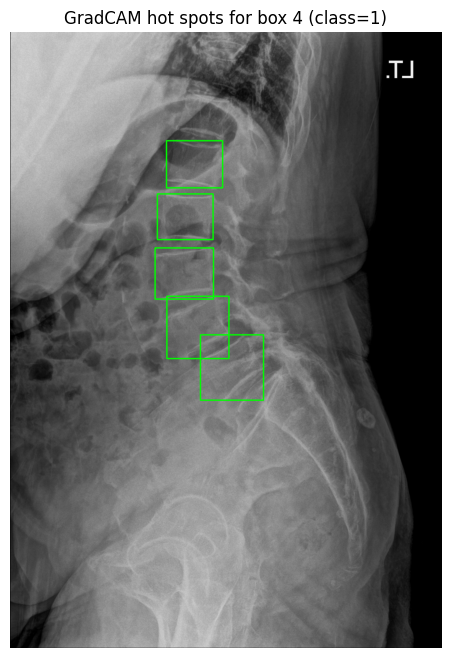

In [48]:
# 5. 바운딩박스별로 class=1에 대해 GradCAM
for i, (box, cls) in enumerate(zip(boxes, classes)):
    if int(cls) == 1:
        feature_maps.clear()
        grads.clear()
        with torch.enable_grad():
            out = model.model(input_tensor)
            if isinstance(out, tuple):
                out = out[0]  # tuple 형태라면 tensor만 꺼내기
            # out: [batch, num_boxes, 5+num_classes]
            # box별 class=1 logit score에 대해서 backward
            # i번째 바운딩박스에 대해
            score = out[0, i, 5+1]  # 1이 class=1 index
            model.model.zero_grad()
            score.backward(retain_graph=True)

        # GradCAM 계산
        feature_map = feature_maps[0].detach().cpu().numpy()[0]  # [C, H, W]
        gradient = grads[0].detach().cpu().numpy()[0]            # [C, H, W]
        weights = gradient.mean(axis=(1,2))                      # [C]
        cam = (feature_map * weights[:, None, None]).sum(axis=0)
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (image.shape[1], image.shape[0]))
        cam -= cam.min()
        if cam.max() != 0:
            cam /= cam.max()
        else:
            cam[:] = 0

        # 바운딩박스만 마스킹
        x1, y1, x2, y2 = map(int, box)
        # box 영역의 gradcam 값만 추출
        cam_box = cam[y1:y2, x1:x2]

        # threshold로 hot spot만 강조
        THRESHOLD = 0.0005
        mask = (cam_box > THRESHOLD).astype(np.uint8)

        # box 내부 원본 patch
        orig_patch = image[y1:y2, x1:x2]

        # box 내부 heatmap
        heatmap_box = cv2.applyColorMap(np.uint8(255 * cam_box), cv2.COLORMAP_JET)

        # hot spot 부분만 heatmap, 나머지는 원본 유지
        overlay_patch = orig_patch.copy()
        overlay_patch[mask == 1] = cv2.addWeighted(orig_patch, 0.5, heatmap_box, 0.5, 0)[mask == 1]

        # 전체 이미지를 복사하고, box 영역만 교체
        overlayed = image.copy()
        overlayed[y1:y2, x1:x2] = overlay_patch

        plt.figure(figsize=(8, 8))
        plt.imshow(overlayed)
        plt.axis('off')
        plt.title(f'GradCAM hot spots for box {i} (class=1)')
        plt.show()

In [51]:
print("box", i, "class=1 score:", out[0, i, 5+1].item())
print("box", i, "conf:", scores[i], "class=1 score:", out[0, i, 5+1].item())

box 4 class=1 score: 1.926563709275797e-05
box 4 conf: 0.8873095 class=1 score: 1.926563709275797e-05


In [52]:
print("box", i, "class scores:", out[0, i, 5:].detach().cpu().numpy())


box 4 class scores: [ 1.6931e-05  1.9266e-05  2.5765e-05 ...  9.6188e-05  9.6982e-05  0.00012299]
